# **Final Project Task 1 - Census Data Preprocess**

Requirements

- Target variable specification:
    - The target variable for this project is hours-per-week. 
    - Ensure all preprocessing steps are designed to support regression analysis on this target variable.
- Encode data  **3p**
- Handle missing values if any **1p**
- Correct errors, inconsistencies, remove duplicates if any **1p**
- Outlier detection and treatment if any **1p**
- Normalization / Standardization if necesarry **1p**
- Feature engineering **3p**
- Train test split, save it.
- Others?


Deliverable:

- Notebook code with no errors.
- Preprocessed data as csv.

# ______________________________________________________________________________________

### For a better process, the steps I have taken are in this order: 

 1. Load
 2. Deal with missing values
 3. Feature engineering
 4. Remove duplicates, inconsistencies
 5. Normalisation/Standardisation
 5. Encoding
 6. Outliers
 7. Train-test split


# 1. Load

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [101]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# 2.  Handle missing values if any


#### Discover missing values

In [102]:
(data == "?").sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

#### Replace with NaN

In [103]:
data = data.replace("?", np.nan)

In [104]:
data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [105]:
cols_missing = data[['workclass', 'occupation', 'native-country']]

cols_missing.head()

,workclass,occupation,native-country
0,State-gov,Adm-clerical,United-States
1,Self-emp-not-inc,Exec-managerial,United-States
2,Private,Handlers-cleaners,United-States
3,Private,Handlers-cleaners,United-States
4,Private,Prof-specialty,Cuba


#### Convert to percent

In [106]:
missing_percent = (cols_missing.isna().sum() / len(data)) * 100

missing_percent 

workclass         5.638647
occupation        5.660146
native-country    1.790486
dtype: float64

#### Generally, less than 5% missing data is considered inconsequential.


Key Considerations:

<5% (Negligible): Often ignored or handled via simple deletion without significant bias.

5–10% (Manageable): Imputation methods are recommended over deletion.

10–20% (Concern): Requires careful handling as it can lead to bias, notes NIH.

#### Our percentage of missing data is over 5% so they will be converted to a new variable.

In [107]:
data["workclass"] = data["workclass"].fillna("Unknown")
data["occupation"] = data["occupation"].fillna("Unknown")
data["native-country"] = data["native-country"].fillna("Unknown")

In [108]:
data[cols_missing.columns].isna().sum()

workclass         0
occupation        0
native-country    0
dtype: int64

# 3. Feature Engineering

#### Transform workclass to reduce data noise

In [109]:
data["workclass"].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', 'Unknown', 'Self-emp-inc', 'Without-pay',
       'Never-worked'], dtype=object)

In [110]:
workclass_map = {
    "Federal-gov": "Government",
    "State-gov": "Government",
    "Local-gov": "Government",
    "Self-emp-not-inc": "Self-employed",
    "Self-emp-inc": "Self-employed",
    "Private": "Private",
    "Without-pay": "Not-working",
    "Never-worked": "Not-working",
    "Unknown": "Unknown"
}

data["workclass_group"] = data["workclass"].map(workclass_map)
data["workclass_group"].value_counts()


workclass_group
Private          22696
Government        4351
Self-employed     3657
Unknown           1836
Not-working         21
Name: count, dtype: int64

#### Transform education 

In [111]:
data.education.unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [112]:
education_map = {
    # Primary
    'Preschool': 'Primary',
    '1st-4th': 'Primary',
    '5th-6th': 'Primary',
    '7th-8th': 'Primary',
    '9th': 'Primary',
    '10th': 'Primary',
    '11th': 'Primary',

    # Secondary
    '12th': 'Secondary',
    'HS-grad': 'Secondary',
    'Some-college': 'Secondary',
    'Assoc-voc': 'Secondary',
    'Assoc-acdm': 'Secondary',

    # Higher
    'Bachelors': 'Higher',
    'Masters': 'Higher',
    'Doctorate': 'Higher',
    'Prof-school': 'Higher'
}


In [113]:
data['education_level'] = data['education'].map(education_map)


In [114]:
data[['education', 'education_level']].head(10)


,education,education_level
0,Bachelors,Higher
1,Bachelors,Higher
2,HS-grad,Secondary
3,11th,Primary
4,Bachelors,Higher
5,Masters,Higher
6,9th,Primary
7,HS-grad,Secondary
8,Masters,Higher
9,Bachelors,Higher


In [115]:
data.education_level.value_counts()

education_level
Secondary    20674
Higher        8067
Primary       3820
Name: count, dtype: int64

#### Transform Age into 3 variables 

In [116]:
data["age_group"] = pd.cut(data["age"], bins=[0,25,50,100], labels=["Young","Adult","Senior"])


#### Transform marital-status

In [117]:
marital_map = {
    "Never-married": "Single",
    "Divorced": "Previously_married",
    "Separated": "Previously_married",
    "Widowed": "Previously_married",
    "Married-civ-spouse": "Married",
    "Married-AF-spouse": "Married",
    "Married-spouse-absent": "Married"
}

data["marital_group"] = data["marital-status"].map(marital_map)
data["marital_group"].value_counts()


marital_group
Married               15417
Single                10683
Previously_married     6461
Name: count, dtype: int64

#### Transform occupation to reduce data noise

In [118]:
data["occupation"].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', 'Unknown', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [119]:
occupation_map = {
    "Exec-managerial": "Professional",
    "Prof-specialty": "Professional",
    "Tech-support": "Professional",
    "Sales": "Office",
    "Adm-clerical": "Office",
    "Craft-repair": "Technical",
    "Machine-op-inspct": "Technical",
    "Transport-moving": "Technical",
    "Farming-fishing": "Agriculture",
    "Handlers-cleaners": "Service",
    "Priv-house-serv": "Service",
    "Other-service": "Service",
    "Protective-serv": "Security",
    "Armed-Forces": "Security",
    "Unknown": "Unknown"
}

data["occupation_group"] = data["occupation"].map(occupation_map)
data["occupation_group"].value_counts()

occupation_group
Professional    9134
Technical       7698
Office          7420
Service         4814
Unknown         1843
Agriculture      994
Security         658
Name: count, dtype: int64

#### Verify and transform -Native-country- variable

In [120]:
data["native-country"].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', 'Unknown', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [121]:
data["native-country"].value_counts().iloc[:5]

native-country
United-States    29170
Mexico             643
Unknown            583
Philippines        198
Germany            137
Name: count, dtype: int64

##### The vast majority of entries are from USA, so the other countries are going to be transformed into ”Non-US”

In [122]:
data["native_region"] = data["native-country"].apply(lambda x: "United-States" if x == "United-States" else "Non-US")

In [123]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,capital-loss,hours-per-week,native-country,income,workclass_group,education_level,age_group,marital_group,occupation_group,native_region
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,0,40,United-States,<=50K,Government,Higher,Adult,Single,Office,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,0,13,United-States,<=50K,Self-employed,Higher,Adult,Married,Professional,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,0,40,United-States,<=50K,Private,Secondary,Adult,Previously_married,Service,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,0,40,United-States,<=50K,Private,Primary,Senior,Married,Service,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,0,40,Cuba,<=50K,Private,Higher,Adult,Married,Professional,Non-US


#### Delete unneccesary columns

In [124]:
data = data.drop(["education","age","native-country","occupation","relationship", "marital-status"], axis=1)

In [125]:
data.head()

,workclass,fnlwgt,education-num,race,sex,capital-gain,capital-loss,hours-per-week,income,workclass_group,education_level,age_group,marital_group,occupation_group,native_region
0,State-gov,77516,13,White,Male,2174,0,40,<=50K,Government,Higher,Adult,Single,Office,United-States
1,Self-emp-not-inc,83311,13,White,Male,0,0,13,<=50K,Self-employed,Higher,Adult,Married,Professional,United-States
2,Private,215646,9,White,Male,0,0,40,<=50K,Private,Secondary,Adult,Previously_married,Service,United-States
3,Private,234721,7,Black,Male,0,0,40,<=50K,Private,Primary,Senior,Married,Service,United-States
4,Private,338409,13,Black,Female,0,0,40,<=50K,Private,Higher,Adult,Married,Professional,Non-US


# 4. Correct errors, inconsistencies, remove duplicates if any

#### Find the duplicates

In [126]:
duplicates = data.duplicated().sum()

print(f"Numarul de duplicate este de:", {duplicates})

Numarul de duplicate este de: {np.int64(124)}


In [127]:
data[data.duplicated()]


,workclass,fnlwgt,education-num,race,sex,capital-gain,capital-loss,hours-per-week,income,workclass_group,education_level,age_group,marital_group,occupation_group,native_region
3261,Private,108658,9,White,Male,0,0,40,<=50K,Private,Secondary,Adult,Single,Technical,United-States
3692,Private,271828,9,White,Male,0,0,40,>50K,Private,Secondary,Adult,Married,Technical,United-States
3781,Private,200973,9,White,Female,0,0,40,<=50K,Private,Secondary,Young,Single,Office,United-States
4277,Private,180052,10,White,Male,0,0,20,<=50K,Private,Secondary,Young,Single,Office,United-States
4299,Unknown,124242,10,White,Female,0,0,40,<=50K,Unknown,Secondary,Young,Single,Unknown,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31632,Private,225193,9,White,Male,0,0,40,<=50K,Private,Secondary,Adult,Married,Office,United-States
31860,Private,224640,10,White,Female,0,0,40,<=50K,Private,Secondary,Young,Single,Office,United-States
31993,Private,251579,10,White,Male,0,0,14,<=50K,Private,Secondary,Young,Single,Service,United-States
32323,Private,188246,9,White,Male,0,0,40,<=50K,Private,Secondary,Adult,Married,Technical,United-States


#### Delete duplicates

In [128]:
data = data.drop_duplicates()

In [129]:
print("Duplicate după ștergere:", data.duplicated().sum())

Duplicate după ștergere: 0


# 5. Outlier detection and treatment if any 

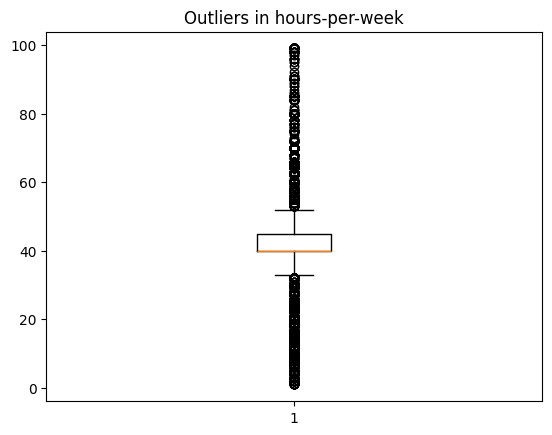

In [130]:
plt.boxplot(data["hours-per-week"])
plt.title("Outliers in hours-per-week")
plt.show()


#### Outliers were detected using boxplots. These values correspond to individuals working unusually high hours per week. As they represent valid real-world observations, they were retained in the dataset.

# 6. Normalization / Standardization if necesarry

In [131]:

numeric_cols = ["fnlwgt", "capital-gain", "capital-loss", "education-num"]

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


# 7. Encode

#### One-hot encoding categorical variables into numerical format without imposing ordinal relationships.

In [132]:
categorical_cols = [
    "sex", "race", "workclass_group",
    "education_level", "marital_group",
    "occupation_group", "native_region",
    "age_group"
]

encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded = encoder.fit_transform(data[categorical_cols])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

data = pd.concat([data.drop(categorical_cols, axis=1).reset_index(drop=True),
                  encoded_df.reset_index(drop=True)], axis=1)
data.head()

,workclass,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,sex_Male,race_Asian-Pac-Islander,race_Black,...,marital_group_Single,occupation_group_Office,occupation_group_Professional,occupation_group_Security,occupation_group_Service,occupation_group_Technical,occupation_group_Unknown,native_region_United-States,age_group_Senior,age_group_Young
0,State-gov,-1.063194,1.134097,0.147619,-0.217093,40,<=50K,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Self-emp-not-inc,-1.008337,1.134097,-0.146205,-0.217093,13,<=50K,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Private,0.244372,-0.420627,-0.146205,-0.217093,40,<=50K,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,Private,0.424940,-1.197989,-0.146205,-0.217093,40,<=50K,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,Private,1.406470,1.134097,-0.146205,-0.217093,40,<=50K,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 8. Train test split, save it.

In [133]:

X = data.drop("hours-per-week", axis=1)
y = data["hours-per-week"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)


data.to_csv("preprocessed_census_data.csv", index=False)